# Firestore to AI Platform 

In [2]:
# !pip install firebase-admin

In [1]:
import pandas as pd
import numpy as np
from numpy.random import choice, randint
import matplotlib.pyplot as plt

import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

cred = credentials.Certificate('service-account.json')
app = firebase_admin.initialize_app(cred)
db = firestore.client()

print('initialized')

initialized


## Firestore Write and Read Data

In [3]:
devs = db.collection('developers')

In [4]:
languages = { 
  u'python': 50, 
  u'rust': 25, 
  u'typescript': 10, 
  u'javascript': 0,
  u'coffescript': -10,
  u'elm': -2,
  u'cobol': -50
}


for i in range(0, 200):
    dev = {
        'firebase': randint(0, 2),
        'language': choice(list(languages.keys())),
        'age': randint(10, 99)
      }
  
    r = randint(-25, 25)
    dev['happiness'] = r + languages[dev['language']] + (25 if dev['firebase'] else -25)
  
    devs.add(dev)

In [5]:
docs = devs.get()
data = []
for doc in docs:
    data.append(doc.to_dict())
    df = pd.DataFrame(data)
    
df.to_csv('data.csv', index=False)

## Exploratory Analysis

In [6]:
df = pd.read_csv('data.csv')
df.sample(10)

,age,firebase,happiness,language
38,65,1,-27,cobol
7,85,1,63,rust
19,68,1,43,elm
90,24,0,-36,javascript
78,69,0,14,python
194,79,0,-53,coffescript
151,15,0,-62,cobol
82,28,1,53,typescript
61,46,0,8,python
195,85,0,-6,javascript


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


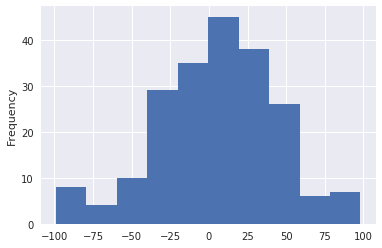

In [7]:
df['happiness'].plot.hist()

In [8]:
df.describe()

,age,firebase,happiness
count,208.000000,208.000000,208.000000
mean,53.913462,0.572115,6.096154
std,25.290051,0.495966,39.567107
min,10.000000,0.000000,-99.000000
25%,31.750000,0.000000,-18.250000
50%,54.500000,1.000000,6.000000
75%,76.000000,1.000000,32.250000
max,98.000000,1.000000,98.000000


## Data Cleaning

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['language'] = le.fit_transform(df['language'])
le.classes_

array(['cobol', 'coffescript', 'elm', 'javascript', 'python', 'rust',
       'typescript'], dtype=object)

In [12]:
df.sample(5)

,age,firebase,happiness,language
187,44,1,-8,1
51,36,0,-52,2
167,15,0,-11,6
4,27,0,27,4
151,15,0,-62,0


In [13]:
x = df.drop(labels='happiness', axis=1)
y = df['happiness']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=23)
X_train.head()

,age,firebase,language
92,47,1,6
148,78,1,6
132,63,1,3
45,91,0,0
59,76,1,6


## Training a Random Forest Model

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

model = RandomForestRegressor(max_depth=3, random_state=23, n_estimators=500)
model.fit(X_train, y_train)

preds = model.predict(X_test)

print("Model Mean Absolute Error MAE {}".format(mean_absolute_error(y_test, preds)))

Model Mean Absolute Error MAE 15.19944302504296


In [15]:
randos = randint(-100, high=100, size=len(y_test))
print("Random Predictions MAE {}".format(mean_absolute_error(y_test, randos)))

Random Predictions MAE 52.666666666666664


## Analyze feature importance

In [16]:
pd.DataFrame(data=[model.feature_importances_], columns=x.columns)

,age,firebase,language
0,0.007691,0.453444,0.538865


## Exporting model to AI Platform

In [17]:
from sklearn.externals import joblib
joblib.dump(model, 'model.joblib')

['model.joblib']

In [18]:
from firebase_admin import storage
bucket = storage.bucket(name='machine-learning-in-the-cloud.appspot.com')

In [19]:
b = bucket.blob('happy-v1/model.joblib')
b.upload_from_filename('model.joblib')
print('model uploaded!')

model uploaded!


In [20]:
!python --version

Python 3.5.6 :: Anaconda, Inc.


In [22]:
import sklearn
sklearn.__version__

'0.19.1'